In [2]:
import arviz as az
import numpyro
from numpyro.infer import Predictive, log_likelihood
import jax
import jax.random as random
import jax.numpy as jnp
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import dill
import seaborn as sns

# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
import bnns.model_configs
from datasets.synthetic import SyntheticDataset
from datasets.uci import UCIDataset, dataset_names, load_standard_splits
from utils import normalize

plt.style.use("seaborn-v0_8-whitegrid")

/home/rasmuslovstad/Programs/assignments/thesis/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
model_names = [name for name in dir(bnns.model_configs)]
models = [getattr(bnns.model_configs, name) for name in model_names]
#datasets = [SyntheticDataset()] + [UCIDataset(name) for name in dataset_names]
dataset = SyntheticDataset()
dataset_name = "synthetic"

In [7]:
# Adjust as needed
SAMPLE_PATH = "../samples/synthetic-1"
DATASET = "SyntheticDataset"
SEED = 10


# Load samples
def load_samples():
    methods = os.listdir(SAMPLE_PATH)
    samples = []
    for method in methods:
        path = os.path.join(SAMPLE_PATH, method, "synthetic")
        if method == "SVI":
            splits = os.listdir(path)
            for split in splits:
                with open(os.path.join(path, split), "rb") as f:
                    svi_result = dill.load(f)
                model_name = "_".join(split.split(".")[0].split("_")[:-1])
                split_ind = split.split(".")[0].split("_")[-1]
                model = getattr(bnns.model_configs, model_name)
                params = svi_result["params"]
                guide = svi_result["guide"]
                predictive = Predictive(guide, params=params, num_samples=1)
                post_draws = predictive(jax.random.PRNGKey(SEED), None)
                samples.append({
                    "model": model,
                    "method": method,
                    "method_name": "MAP" if method == "SVI" else "NUTS" if method == "HMC" else method,
                    "model": model_name,
                    "split": split_ind,
                    "post_draws": post_draws
                })
        if method == "HMC":
            splits = os.listdir(path)
            for split in splits:
                if ".nc" not in split:
                    continue
                inference_data = az.from_netcdf(os.path.join(path, split))
                model_name = "_".join(split.split(".")[0].split("_")[:-1])
                split_ind = split.split(".")[0].split("_")[-1]
                model = getattr(bnns.model_configs, model_name)

                post_draws = inference_data.to_dict()["posterior"]
                post_draws.pop("y_probs", None)

                with open(os.path.join(path, split.replace(".nc", "_metadata.dill")), "rb") as f:
                    metadata = dill.load(f)
                samples.append({
                    "model": model,
                    "method": method,
                    "method_name": "MAP" if method == "SVI" else "NUTS" if method == "HMC" else method,
                    "model": model_name,
                    "split": split_ind,
                    "post_draws": post_draws,
                    "inference_data": inference_data,
                    "time_spanned": metadata["time_spanned"],
                    "accept_prob": metadata["accept_prob"],
                })
    return samples
samples = load_samples()

In [74]:
def rmse(model, post_draws, X, y, batch_ndims):
    predictive = Predictive(model, post_draws, batch_ndims=batch_ndims)
    predictions = predictive(jax.random.PRNGKey(SEED), X, D_Y=1, sigma=dataset.noise_level)["y_loc"]
    if predictions.ndim == 2 and predictions.shape[0] == 1:
        predictions = predictions[0]
    return jnp.sqrt(((y - predictions)**2).mean()), predictions

def batch_nll(model, post_draws, X, y, batch_ndims):
    batch_size = 5120
    n_batches = X.shape[0] // batch_size + 1
    nlls = []
    post_draws = post_draws.copy()
    post_draws.pop("y_loc", None)

    for i in range(n_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        nll = -log_likelihood(model, post_draws, X[start:end], y[start:end], sigma=dataset.noise_level, batch_ndims=batch_ndims)["y"]
        nlls.append(nll)
    return jnp.mean(jnp.concat(nlls, axis=-1))

In [77]:

results = []
preds = []
for sample_dict in samples:
    model = getattr(bnns.model_configs, sample_dict["model"])
    post_draws = sample_dict["post_draws"]
    batch_ndims = 1 if sample_dict["method"] == "SVI" else 2

    split = dataset.splits[int(sample_dict["split"])]

    X_train = dataset.X_train
    X_train_normalized, X_train_mean, X_train_std = normalize(X_train, None, None)
    y_train = dataset.y_train

    X_test_between = dataset.X_test_between
    X_test_between_normalized, _, _ = normalize(X_test_between, X_train_mean, X_train_std)
    y_test_between = dataset.y_test_between

    X_test_in = dataset.X_test_in
    X_test_in_normalized, _, _ = normalize(X_test_in, X_train_mean, X_train_std)
    y_test_in = dataset.y_test_in

    X_test_entire = dataset.X_test_entire
    X_test_entire_normalized, _, _ = normalize(X_test_entire, X_train_mean, X_train_std)
    y_test_entire = dataset.y_test_entire

    if sample_dict["method"] == "HMC":
        X_train = X_train_normalized
        X_test_between = X_test_between_normalized
        X_test_in = X_test_in_normalized
        X_test_entire = X_test_entire_normalized

    # train_nll = batch_nll(model, post_draws, X_train, y_train, batch_ndims)
    # test_between_nll = batch_nll(model, post_draws, X_test_between, y_test_between, batch_ndims)
    # test_in_nll = batch_nll(model, post_draws, X_test_in, y_test_in, batch_ndims)
    # test_entire_nll = batch_nll(model, post_draws, X_test_entire, y_test_entire, batch_ndims)
    post_draws = post_draws.copy()
    post_draws.pop("y_loc", None)
    train_nll = -log_likelihood(model, post_draws, X=X_train, y=y_train, sigma=dataset.noise_level, batch_ndims=batch_ndims)["y"].mean()
    test_between_nll = -log_likelihood(model, post_draws, X=X_test_between, y=y_test_between, sigma=dataset.noise_level, batch_ndims=batch_ndims)["y"].mean()
    test_in_nll = -log_likelihood(model, post_draws, X=X_test_in, y=y_test_in, sigma=dataset.noise_level, batch_ndims=batch_ndims)["y"].mean()
    test_entire_nll = -log_likelihood(model, post_draws, X=X_test_entire, y=y_test_entire, sigma=dataset.noise_level, batch_ndims=batch_ndims)["y"].mean()

    train_rmse, y_pred_train = rmse(model, post_draws, X_train, y_train, batch_ndims)
    test_between_rmse, y_pred_test_between = rmse(model, post_draws, X_test_between, y_test_between, batch_ndims)
    test_in_rmse, y_pred_test_in = rmse(model, post_draws, X_test_in, y_test_in, batch_ndims)
    test_entire_rmse, y_pred_test_entire = rmse(model, post_draws, X_test_entire, y_test_entire, batch_ndims)

    results.append({
        "method": sample_dict["method"],
        "model": sample_dict["model"].split("_")[0],
        "width": int(sample_dict["model"].split("_")[1]),
        "split": sample_dict["split"],
        "train_nll": train_nll.mean(),
        "train_rmse": train_rmse,
        "test_between_nll": test_between_nll.mean(),
        "test_between_rmse": test_between_rmse,
        "test_in_nll": test_in_nll.mean(),
        "test_in_rmse": test_in_rmse,
        "test_entire_nll": test_entire_nll.mean(),
        "test_entire_rmse": test_entire_rmse,
    })
    preds.append({
        "y_train": y_train,
        "y_pred_train": y_pred_train,
        "y_pred_between": y_pred_test_between,
        "y_pred_in": y_pred_test_in,
        "y_pred_entire": y_pred_test_entire,
    })
results = pd.DataFrame(results)
results.sort_values(by=["method", "model", "width"], inplace=True)
results

,method,model,width,split,train_nll,train_rmse,test_between_nll,test_between_rmse,test_in_nll,test_in_rmse,test_entire_nll,test_entire_rmse
0,HMC,BNN,5,0,-0.9499069,0.09313857,115.1489,1.526647,-0.8692345,0.10143096,65.95646,1.160518
3,HMC,BNN,100,0,-0.99191564,0.08851337,685.20087,3.7056296,-0.81236887,0.10689038,305.81888,2.4787195
1,HMC,CircBNN,5,0,-0.9484016,0.09330003,132.4809,1.6362431,-0.86848813,0.10150451,70.532486,1.199301
4,HMC,CircBNN,100,0,-0.99139446,0.088572234,715.2855,3.7859454,-0.8175862,0.10640115,313.5262,2.509621
2,HMC,SpectralBNN,5,0,-0.9061891,0.097719766,186.77078,1.9398682,-0.8327542,0.10496594,109.66591,1.4902991
5,HMC,SpectralBNN,100,0,-0.99415976,0.08825948,388.94748,2.7940333,-0.86111474,0.10222835,172.75394,1.8662132
7,SVI,BNN,5,0,-1.0651543,0.079811305,106.00157,1.4655048,-1.056484,0.08089036,50.974655,1.0233114
6,SVI,BNN,100,0,-1.087303,0.07698617,84.54407,1.3109365,-1.0651454,0.07981241,63.487156,1.1390417
9,SVI,CircBNN,5,0,-1.0662535,0.079673454,67.037315,1.1697944,-0.9555959,0.09252575,51.18938,1.0254076
8,SVI,CircBNN,100,0,-1.1194729,0.0726875,228.62637,2.1448078,-0.9958672,0.08806581,80.04127,1.2761264


# ESS per layer

/home/rasmuslovstad/Programs/assignments/thesis/venv/lib64/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (50) in plot_ess, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'w0\n0, 0'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'w0\n0, 1'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'w0\n0, 2'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'w0\n0, 3'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<Axes: title={'center': 'w0\n0, 4'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'w0\n0, 5'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'w0\n0, 6'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'w0\n0, 7'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<Axes: title={'center': 'w0\n0, 8'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <Axes: title={'center': 'w0\n0, 9'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        

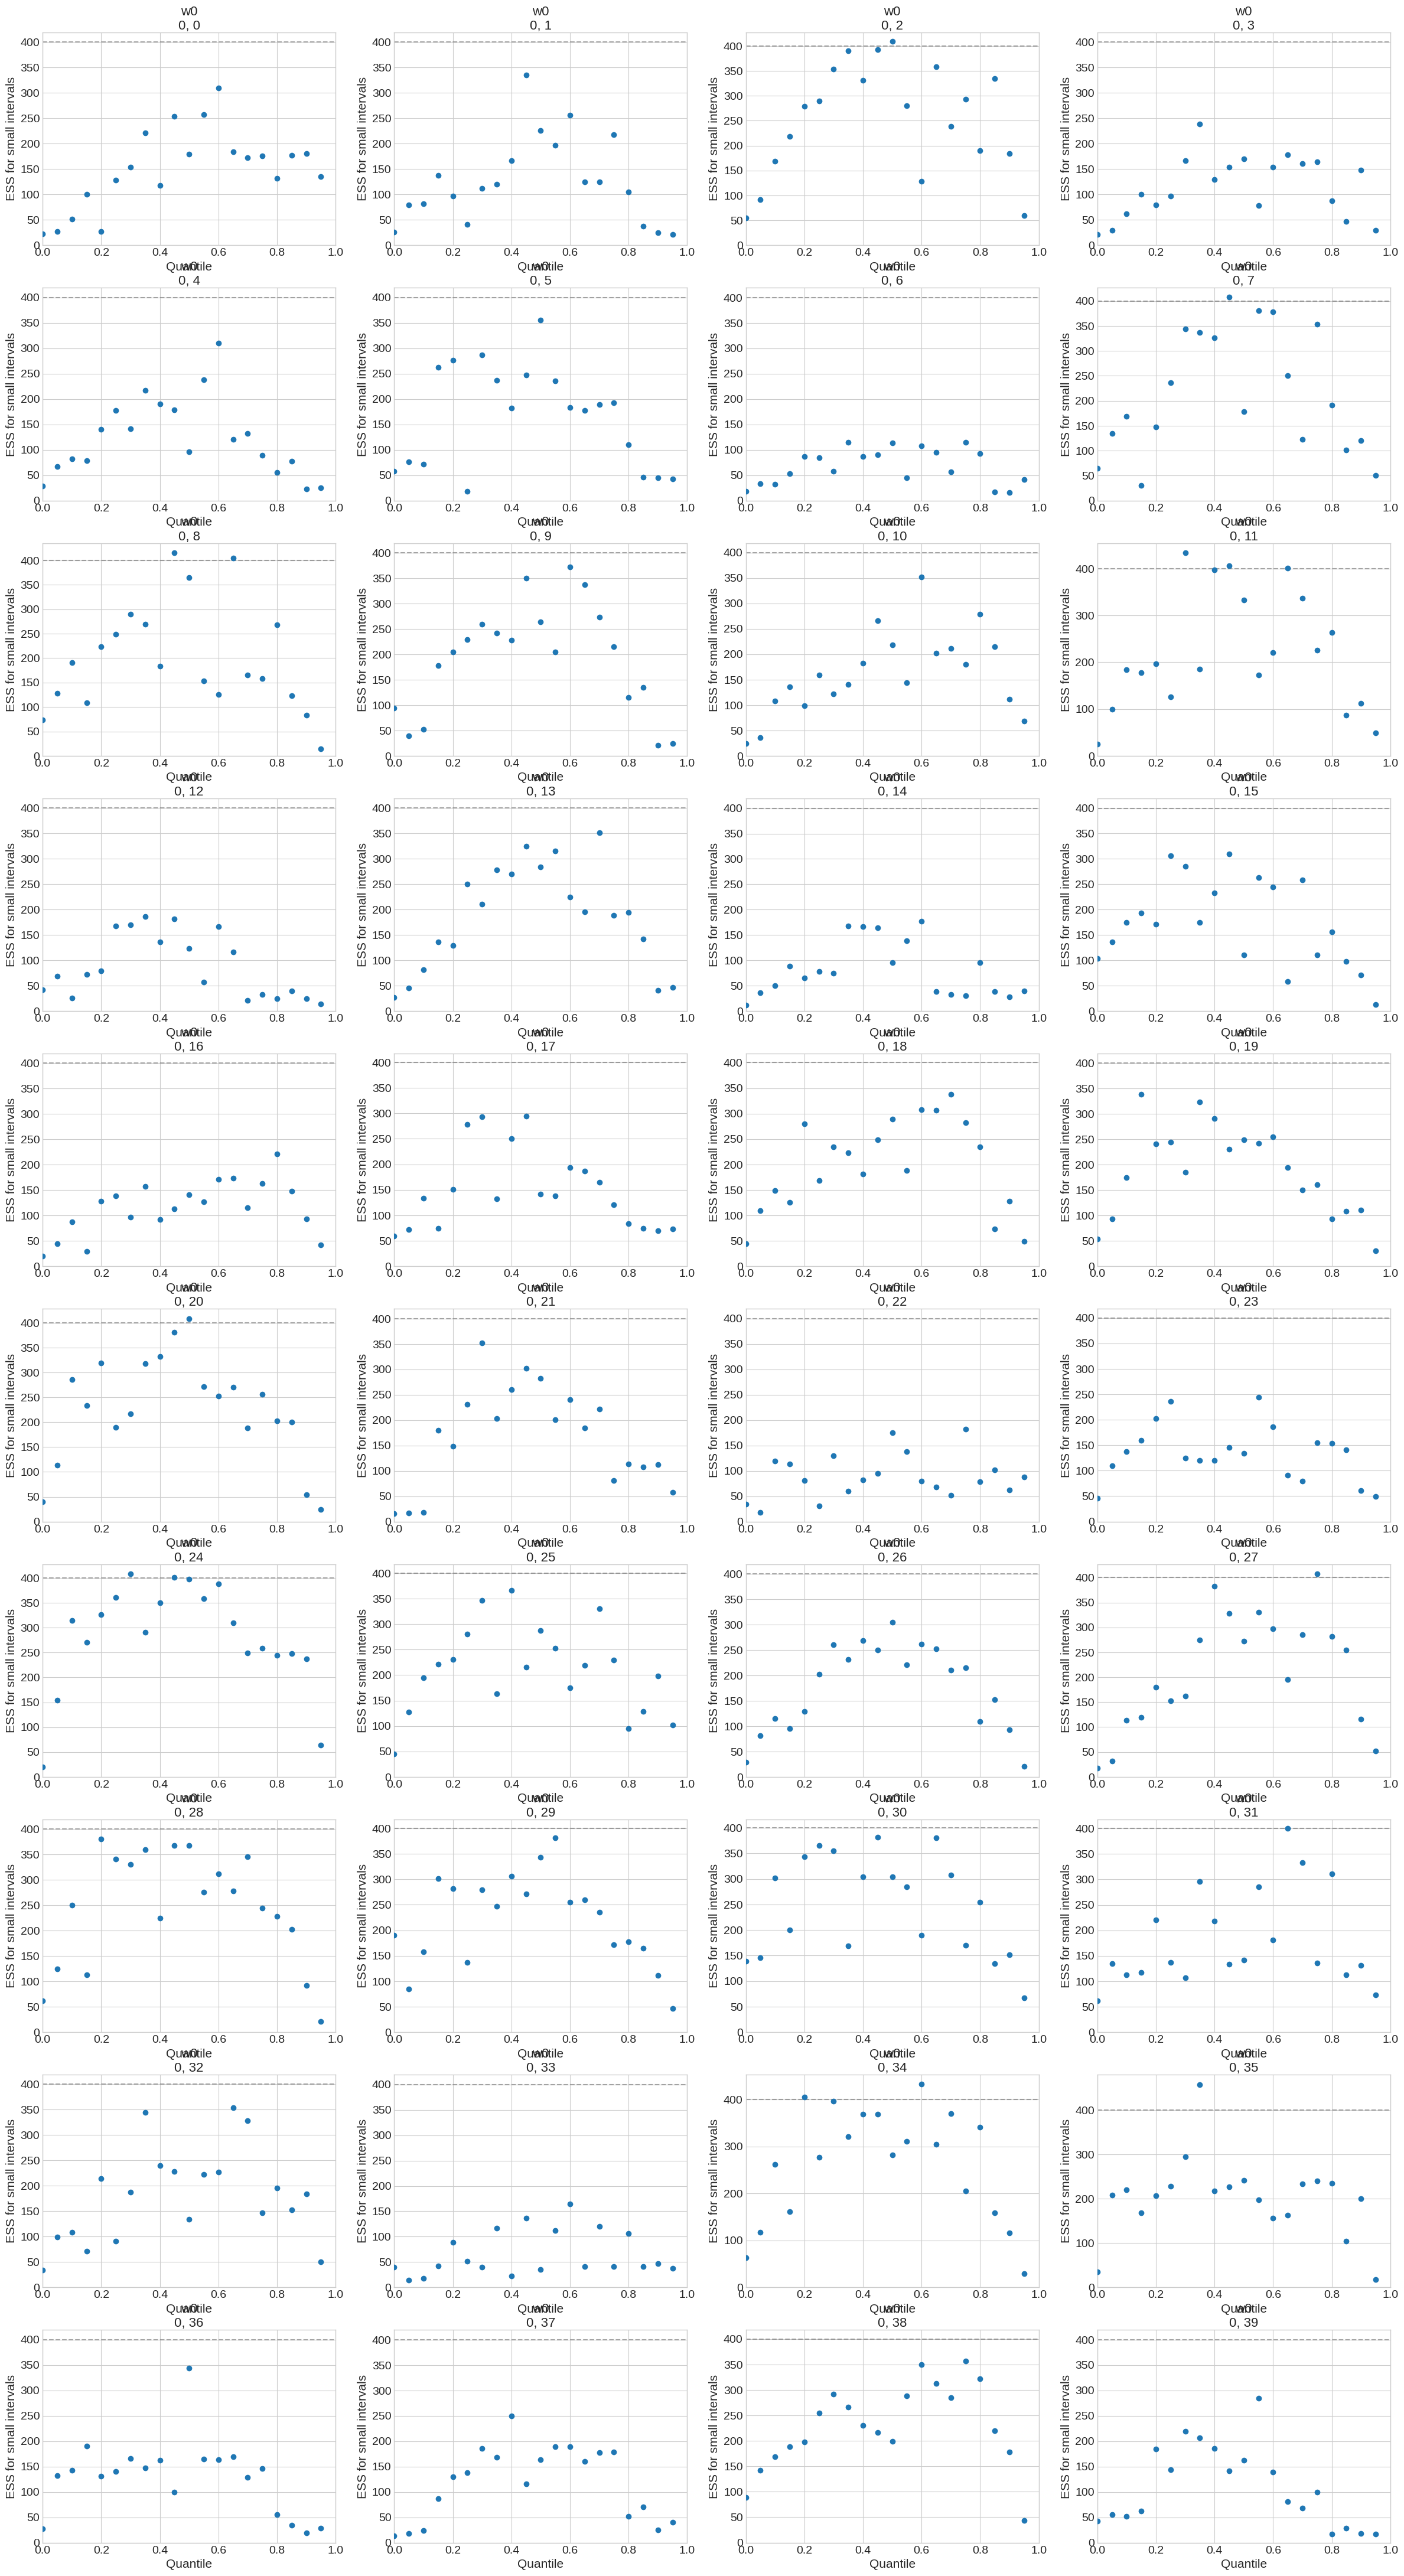

In [ ]:
az.plot_ess(az_datas[1], var_names=["w0"])

# $\hat{r}$ and split-$\hat{r}$
Only relevant when $n_{chains} > 1$

In [5]:
az.rhat(az_datas[0], method="split")

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


<xarray.Dataset> Size: 25kB
Dimensions:      (b0_dim_0: 50, b1_dim_0: 50, b2_dim_0: 1, w0_dim_0: 1,
                  w0_dim_1: 50, w1_dim_0: 50, w1_dim_1: 50, w2_dim_0: 50,
                  w2_dim_1: 1, y_loc_dim_0: 40, y_loc_dim_1: 1)
Coordinates:
  * b0_dim_0     (b0_dim_0) int64 400B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * b1_dim_0     (b1_dim_0) int64 400B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * b2_dim_0     (b2_dim_0) int64 8B 0
  * w0_dim_0     (w0_dim_0) int64 8B 0
  * w0_dim_1     (w0_dim_1) int64 400B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * w1_dim_0     (w1_dim_0) int64 400B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * w1_dim_1     (w1_dim_1) int64 400B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * w2_dim_0     (w2_dim_0) int64 400B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * w2_dim_1     (w2_dim_1) int64 8B 0
  * y_loc_dim_0  (y_loc_dim_0) int64 320B 0 1 2 3 4 5 6 ... 33 34 35 36 37 38 39
  * y_loc_dim_1  (y_loc_dim_1) int64 8B 0
Data variables:
    b0           (b0_dim_0) float64 400B nan nan nan nan nan ... nan nan nan nan
    b1           (b1_dim_0) float64 400B nan nan nan nan nan ... nan nan nan nan
    b2           (b2_dim_0) float64 8B nan
    prec         float64 8B nan
    w0           (w0_dim_0, w0_dim_1) float64 400B nan nan nan ... nan nan nan
    w1           (w1_dim_0, w1_dim_1) float64 20kB nan nan nan ... nan nan nan
    w2           (w2_dim_0, w2_dim_1) float64 400B nan nan nan ... nan nan nan
    y_loc        (y_loc_dim_0, y_loc_dim_1) float64 320B nan nan nan ... nan nan

# Model Comparison
Using Pareto-smoothed EPLD (by $\texttt{arviz.compare}$)

In [6]:
compare_dict = {}
for name, az_data in zip(model_names_in_folder,az_datas):
    compare_dict[name] = az_data
comparison = az.compare(compare_dict)

/home/rasmuslovstad/Programs/assignments/thesis/venv/lib64/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.63 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/rasmuslovstad/Programs/assignments/thesis/venv/lib64/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.63 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

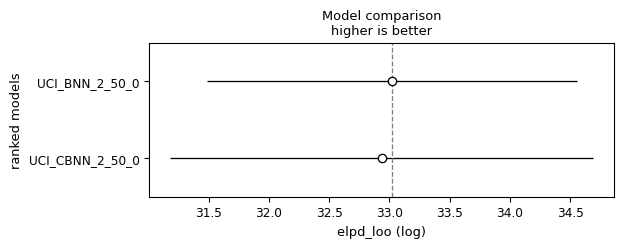

In [7]:
az.plot_compare(comparison)

/home/rasmuslovstad/Programs/assignments/thesis/venv/lib64/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.63 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/rasmuslovstad/Programs/assignments/thesis/venv/lib64/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.63 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn

<Axes: title={'center': 'UCI_BNN_2_50_0 - UCI_CBNN_2_50_0'}, ylabel='ELPD difference'>

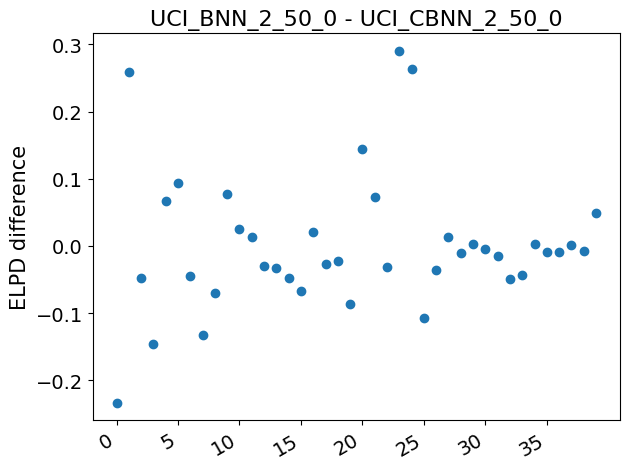

In [8]:
az.plot_elpd(compare_dict, xlabels=True)

# Synthetic data evaluation

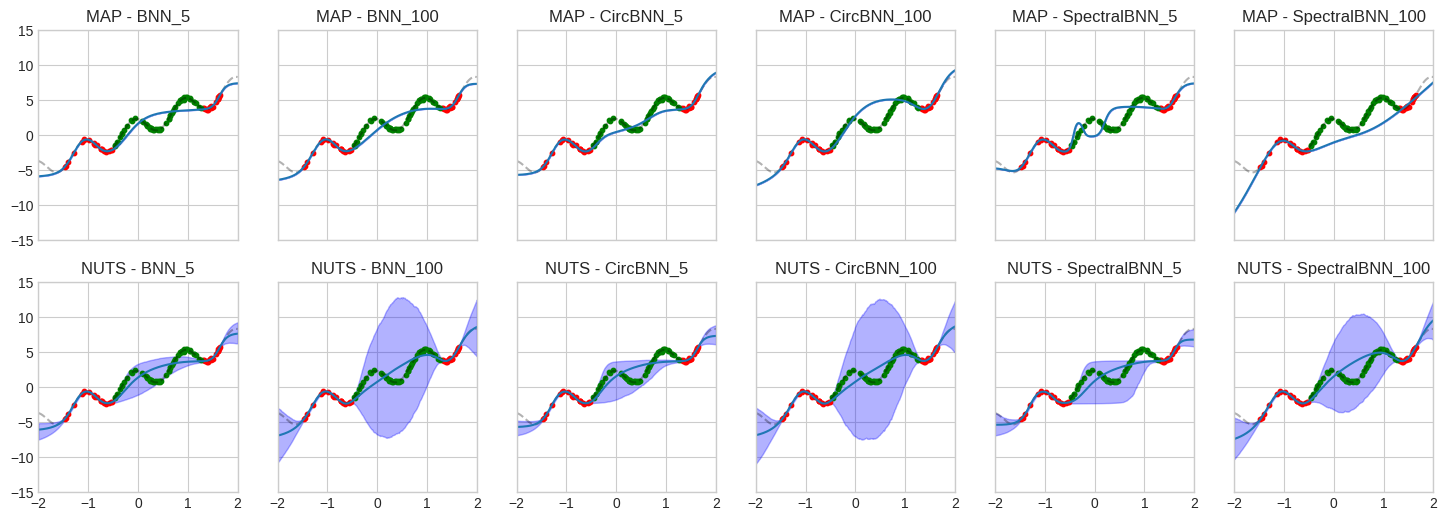

In [9]:
fig, axs = plt.subplots(ncols=len(samples) // 2, nrows=2, figsize=(3*len(samples) // 2, 3 * 2), sharex=True, sharey=True)

samples = sorted(samples, key=lambda x: (x["method_name"], x["model"].split("_")[0], int(x["model"].split("_")[1])))

if len(samples) > 1:
    axs = axs.ravel()

X_train_normalized, X_train_mean, X_train_std = normalize(dataset.X_train, None, None)
X_plot = jnp.array(dataset.X_true).reshape(-1, 1)
X_plot_normalized, _, _ = normalize(X_plot, X_train_mean, X_train_std)
X_train = dataset.X_train
y_train = dataset.y_train
for idx, sample in enumerate(samples):
    model = getattr(bnns.model_configs, sample["model"])
    post_draws = sample["post_draws"]
    batch_ndims = 1 if sample["method"] == "SVI" else 2

    #X_plot = jnp.linspace(X.min(), X.max(), 1000).reshape(-1, 1)

    post_draws_no_y = post_draws.copy()
    post_draws_no_y.pop("y_loc", None)
    
    predictive = Predictive(model, posterior_samples=post_draws_no_y, batch_ndims=batch_ndims)
    y_pred = predictive(jax.random.PRNGKey(SEED), X_plot_normalized if sample["method"] == "HMC" else X_plot, D_Y=1, sigma=dataset.noise_level)["y_loc"]
    if y_pred.ndim == 3 and y_pred.shape[0] == 1:
        y_pred = y_pred[0]
    method = sample["method_name"]
    axs[idx].set_xlim(X_plot.min(), X_plot.max())
    axs[idx].set_ylim(-15, 15)
    axs[idx].set_title(f"{method} - {sample['model']}")
    axs[idx].plot(X_plot, dataset.y_true, "--", color="black", alpha=0.3, label="True Function")
    axs[idx].plot(X_plot.flatten(), y_pred.mean(axis=0), label=sample["model"])

    y_pred_lower, y_pred_upper = np.percentile(y_pred, [2.5, 97.5], axis=0)
    axs[idx].fill_between(X_plot.flatten(), y_pred_lower, y_pred_upper, alpha=0.3, color="blue", label="95% Credible Interval")

    axs[idx].scatter(X_train, y_train, color="red", s=10, label="Train Data")
    axs[idx].scatter(dataset.X_test_between, dataset.y_test_between, color="green", s=10, label="Test Data")

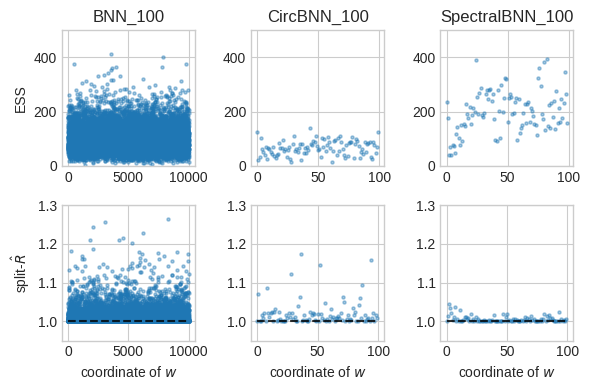

In [10]:
# Amont of parameters in middle layer of BNN, 100 deep
# for sample_dict in samples:
#     if sample_dict["method"] == "SVI":
#         continue
#     inference_data = sample_dict["inference_data"]
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*2, 4))
idx = 0
axs[0, idx].set_ylabel("ESS")
axs[1, idx].set_ylabel("split-$\hat{R}$")
for sample in samples:
    if sample["method"] == "SVI":
        continue
    if "5" in sample["model"]:
        continue
    post_draws = sample["post_draws"].copy()
    if "Spectral" in sample["model"]:
        for i in range(7):
            post_draws.pop(f"w_hat_{i}", None)
    ess_per_layer = numpyro.diagnostics.summary(post_draws)
    axs[0, idx].set_title(f"{sample['model']}")
    value = ess_per_layer["w1"] if "w1" in ess_per_layer else ess_per_layer["w_hat_0_normals"]
    axs[0, idx].scatter(range(len(value["n_eff"].flatten())), value["n_eff"], s=5, alpha=0.4)
    axs[0, idx].set_ylim(0, 500)
    axs[1, idx].scatter(range(len(value["r_hat"].flatten())), value["r_hat"], s=5, alpha=0.4)
    axs[1, idx].set_ylim(0.95, 1.3)
    axs[1, idx].plot([0, len(value["r_hat"].flatten())], [1, 1], "--", color="black", alpha=0.8)
    axs[1, idx].set_xlabel("coordinate of $w$")
    idx += 1
fig.tight_layout()

In [61]:
summaries = [(numpyro.diagnostics.summary(sample["post_draws"]), sample["model"]) for sample in samples]
data = []
for summary, model in summaries:
    ess = summary["w1"]["n_eff"].flatten() if "w1" in summary else summary["w_hat_0_normals"]["n_eff"].flatten()
    rhat = summary["w1"]["r_hat"].flatten() if "w1" in summary else summary["w_hat_0_normals"]["r_hat"].flatten()
    for e, r in zip(ess, rhat):
        data.append({"ess": e, "rhat": r, "model": model})
df_summaries = pd.DataFrame(data)
#summaries = pd.DataFrame([{"ess" : summary[0]["w1"]["n_eff"].flatten(), "rhat" : summary[0]["w1"]["r_hat"].flatten(), "model": summary[1]} for summary in summaries])
sns.boxplot(data=df_summaries, x="model", y="rhat")

TypeError: ufunc 'rfft_n_even' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# UCI Benchmark table (similar to Table 2 in Stein paper)

In [49]:
rows = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        dataset = UCIDataset(dataset_name)
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))): 
            if file_name[-3:] == ".nc":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                az_data = az.from_netcdf(os.path.join(SAMPLE_PATH, dataset_name, file_name))
                samples = az_data.to_dict()["posterior"]
                splits = load_standard_splits(True)[dataset_name]
                split = splits[split_ind]["te"]
                test_X = dataset.data[split][:, :-1]
                test_y = dataset.data[split][:, -1]
                nll = -log_likelihood(model, samples, X=test_X, y=test_y, batch_ndims=2, parallel=True)["y"]
                predictive = Predictive(model, posterior_samples=samples, return_sites=["y"], batch_ndims=2, parallel=True)
                predicted_ys = predictive(model_key, X=test_X, y=None, D_Y=1)["y"]
                rmse = jnp.sqrt(((test_y - predicted_ys)**2).mean())
                rows.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "nll": nll.mean(), "rmse": rmse})
df = pd.DataFrame(rows)

In [38]:
df.groupby(["dataset", "model"]).mean()

,,split,nll,rmse
dataset,model,,,
boston-housing,UCI_BNN_2_50,0.0,83.977463,10.952462


In [34]:
dataset.data[splits[1]["tr"]][:,:-1].std(0).mean()

Array(1.0077528, dtype=float32)

# Report plots

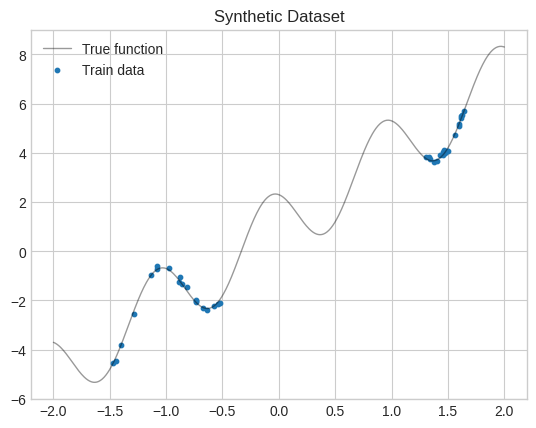

In [22]:
# Plot the data with the underlying function
dataset = SyntheticDataset()
plt.title("Synthetic Dataset")
plt.plot(dataset.X_true, dataset.y_true, lw=1, c="black", alpha=0.4, label="True function")
plt.scatter(dataset.X_train, dataset.y_train, s=10, label="Train data")
plt.legend()

/tmp/ipykernel_5284/2480205984.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,0].set_xticklabels(x_tick_labels)
/tmp/ipykernel_5284/2480205984.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(x_tick_labels)
/tmp/ipykernel_5284/2480205984.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(x_tick_labels)
/tmp/ipykernel_5284/2480205984.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,1].set_xticklabels(x_tick_labels)


[Text(0, 0, 'BNN'), Text(1, 0, 'CircBNN'), Text(2, 0, 'SpectralBNN')]

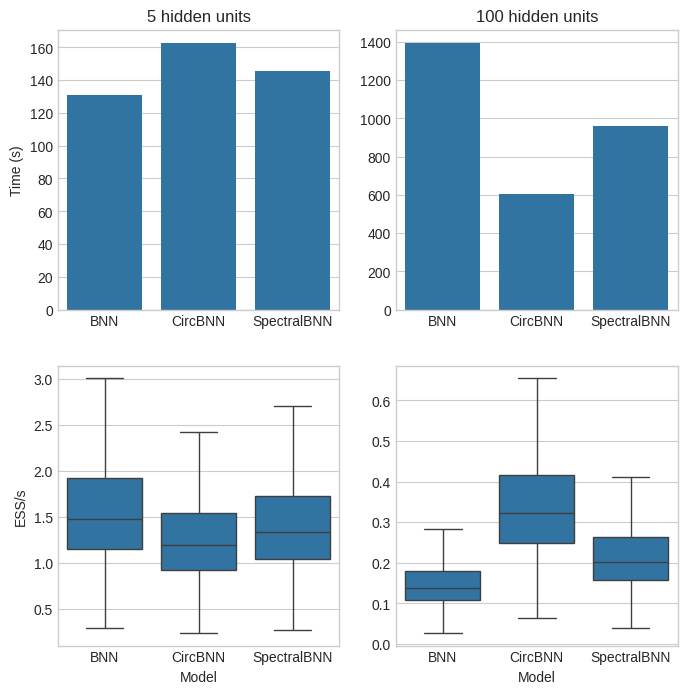

In [54]:
# Plot box plot of ESS
boxplot = []
for sample_dict in samples:
    if sample_dict["method"] == "SVI":
        continue
    post_draws = sample["post_draws"].copy()
    if "Spectral" in sample["model"]:
        for i in range(7):
            post_draws.pop(f"w_hat_{i}", None)
    summary = numpyro.diagnostics.summary(post_draws)
    ess = summary["w1"]["n_eff"].flatten() if "w1" in summary else summary["w_hat_0_normals"]["n_eff"].flatten()
    time_spanned = sample_dict["time_spanned"]
    for e in ess:
        boxplot.append({"ess": e, "time_spanned": float(time_spanned), "ESS/s": e / time_spanned, "Model": sample_dict["model"], "width": sample_dict["model"].split("_")[1]})
boxplot = pd.DataFrame(boxplot)
#sns.barplot(data=boxplot, x="model", y="time_spanned", hue="width")
#g = sns.FacetGrid(boxplot, col="width", col_wrap=3, height=3, sharey=False)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
x_tick_labels = ["BNN", "CircBNN", "SpectralBNN"]
sns.barplot(ax=axs[0,0], data=boxplot.loc[boxplot["width"] == "5"], x="Model", y="time_spanned")
sns.barplot(ax=axs[0,1], data=boxplot.loc[boxplot["width"] == "100"], x="Model", y="time_spanned")
sns.boxplot(ax=axs[1,0], data=boxplot.loc[boxplot["width"] == "5"], x="Model", y="ESS/s")
sns.boxplot(ax=axs[1,1], data=boxplot.loc[boxplot["width"] == "100"], x="Model", y="ESS/s")
axs[0,0].set_title("5 hidden units")
axs[0,1].set_title("100 hidden units")
axs[0,0].set_xlabel(None)
axs[0,1].set_xlabel(None)
axs[0,0].set_ylabel("Time (s)")
axs[0,1].set_ylabel(None)
axs[1,1].set_ylabel(None)
axs[0,0].set_xticklabels(x_tick_labels)
axs[0,1].set_xticklabels(x_tick_labels)
axs[1,0].set_xticklabels(x_tick_labels)
axs[1,1].set_xticklabels(x_tick_labels)